In [2]:
from utils import *
import shap


# read data
file_name = "Estimation Data - Last Two Days - Ads 1 and 3.dta"
file_dir = "..\\data\\"
file_dir_name = file_dir + file_name
data = pd.read_stata(file_dir_name)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [12]:
import shap

In [3]:
# keep advertiser ranks 1, 3
data = data[(data['advertiser_rank'] == 1) | (data['advertiser_rank'] == 3)]

In [5]:

(X, Y, T) = define_xyt(data)


In [6]:

class PropensityModel(BaseEstimator):
    def __init__(self):
        self.lr = LogisticRegression(max_iter=2000)

    def predict_proba(self, X, X_indices=slice(-17,-1)):
        return self.lr.predict_proba(X[:,X_indices])


    
    # X_indices are the ones that are used for the estimation of the propensity score
    def fit(self, X, y, X_indices=slice(-17,-1)):
        self.lr.fit(X[:,X_indices], y)
        return self


# Instantiate propensity_model from the PropensityModel class
propensity_model = PropensityModel()




# Define the hyperparameters to search over
param_grid = {
    # 'n_estimators': [50, 100, 200],
    'n_estimators': [200],
    'max_depth': [10, 20],
    'min_samples_split': [5000, 10000, 15000]
}


In [6]:
X.columns

Index(['previous_clicks_all_ads', 'impression_repeat', 'previous_clicks',
       'impression_repeat_base_ad', 'previous_clicks_base_ad', 'total_visits',
       'visit_s2', 'visit_s4', 'visit_s5', 'visit_s6', 'visit_s8', 'visit_s9',
       'visit_s11', 'visit_s12', 'visit_s14', 'visit_s16', 'visit_s17',
       'visit_s18', 'visit_s19', 'visit_s23', 'visit_s24', 'visit_s25',
       'sub_2', 'sub_4', 'sub_5', 'sub_6', 'sub_8', 'sub_9', 'sub_11',
       'sub_12', 'sub_14', 'sub_16', 'sub_17', 'sub_18', 'sub_19', 'sub_23',
       'sub_24', 'sub_25', 'mobile'],
      dtype='object')

In [7]:
X

,previous_clicks_all_ads,impression_repeat,previous_clicks,impression_repeat_base_ad,previous_clicks_base_ad,total_visits,visit_s2,visit_s4,visit_s5,visit_s6,...,sub_12,sub_14,sub_16,sub_17,sub_18,sub_19,sub_23,sub_24,sub_25,mobile
0,0,49,0,88,0,101,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,2,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,9,0,12,0,21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,3,0,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,2,0,2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156704,0,1,0,6,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3156705,0,5,0,5,0,11,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3156706,0,9,0,8,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3156707,0,3,0,7,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
(X, Y, T) = define_xyt(data)
# find best parameters for the m model
# best_params = m_model_best_estimator(X, Y)
# estimate the casual forest model
# define the causal forest model
cf = CausalForestDML(
                        model_y=RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=3000),
                        model_t=propensity_model,
                        discrete_treatment='True',
                        criterion='het',
                        n_jobs=n_jobs,
                        random_state=42,
                        verbose=0, 
                        n_estimators=300,
                        max_depth=20, 
                        min_samples_split=5000,
                        max_samples=0.15  
    )

# tune the model:
start_time = time.perf_counter()

# # Define the hyperparameters to search over
# cf_param_grid = {
#     # 'n_estimators': [100, 200, 300],
#     'n_estimators': [300],
#     'max_depth': [20],
#     'min_samples_split': [5000],
#     'max_samples': [0.15]
# }

# param_grid = {
#     # 'n_estimators': [50, 100, 200],
#     'n_estimators': [200],
#     'max_depth': [10],
#     'min_samples_split': [3000]
# }


# tune_params = cf.tune(
#             Y=Y,
#             T=T,
#             X=X,
#             params=cf_param_grid)

finish_time = time.perf_counter()

print(f"finished tuning the model in {finish_time - start_time} seconds")

# fit the model using tuned parameters:
start_time = time.perf_counter()

cf.fit(Y=Y, T=T, X=X, inference="blb", cache_values=True)

finish_time = time.perf_counter()
print(f"finished fitting the model in {finish_time - start_time} seconds")

# save the model
file_name = f"..\\results\\main_scenario\\CF - Rank 1 and 3 - Merged Subjects - Corrected.pkl"
joblib.dump(cf, file_name)

finished tuning the model in 2.99999999811007e-05 seconds


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


finished fitting the model in 6848.0352521 seconds


['..\\results\\main_scenario\\CF - Rank 1 and 3 - Merged Subjects - Corrected.pkl']

100%|===================| 1578/1579 [01:19<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


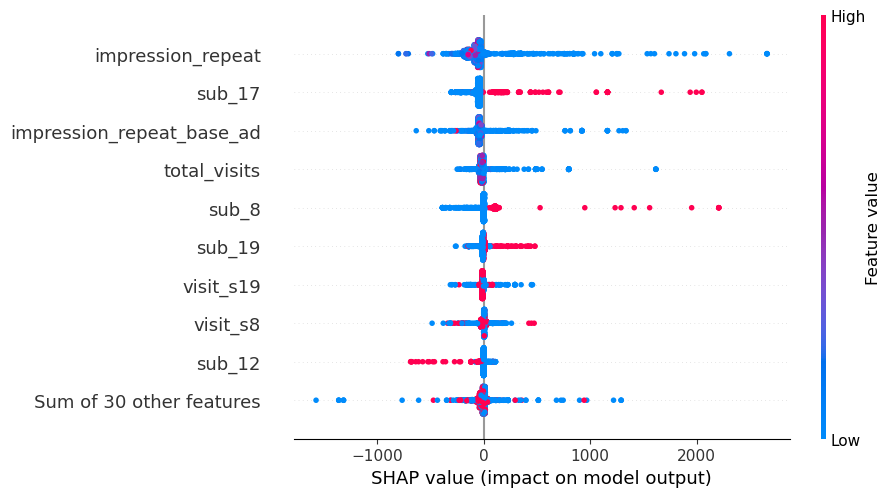

In [13]:
shap_values_1 = cf.shap_values(X[X.index % 2000 == 0])
shap.plots.beeswarm(shap_values_1['is_clicked']['advertiser_rank_3'] / .0025326 * 100)

100%|===================| 3144/3157 [02:41<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


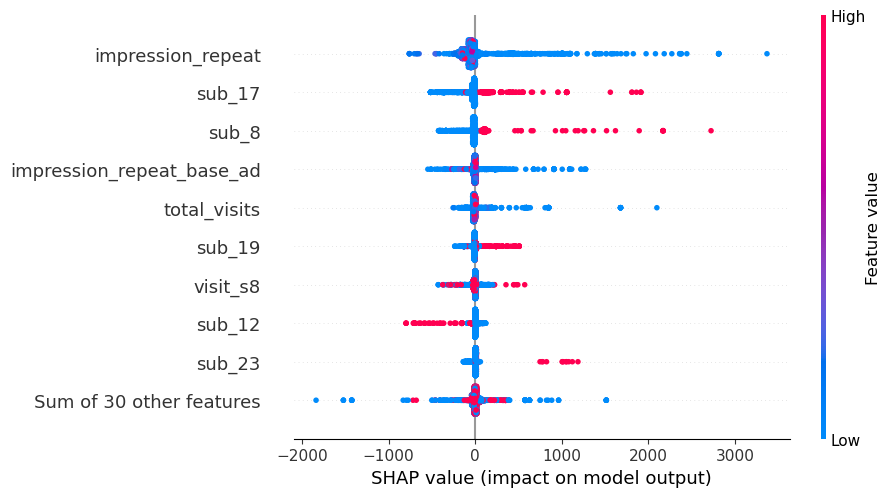

In [14]:
shap_values_1 = cf.shap_values(X[X.index % 1000 == 0])
shap.plots.beeswarm(shap_values_1['is_clicked']['advertiser_rank_3'] / .0025326 * 100)

In [104]:
shap_values_1 = cf.shap_values(X.iloc[0:1000, :])


 98%|===================| 983/1000 [00:41<00:00]        

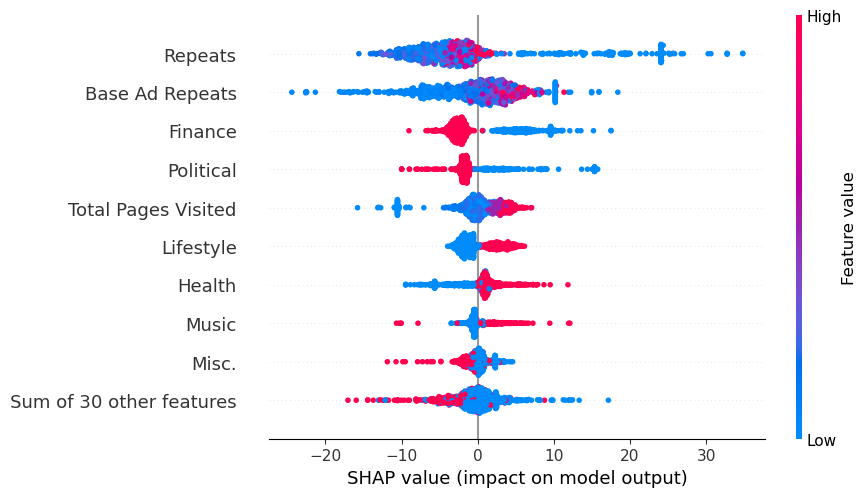

In [105]:
shap.plots.beeswarm(shap_values_1['is_clicked']['advertiser_rank_3'] / .0025326 * 100)    
plt.savefig(f"..\\results\\split 1\\figures\\Treatment Effect Shap Values bw Ad 1, 3.jpg", dpi=600)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <econml.dml.causal_forest.CausalForestDML object at 0x0000021D900CE550>

In [102]:
X.rename(columns={
    'impression_repeat': 'Repeats',
     'impression_repeat_base_ad': 'Base Ad Repeats',
     'visit_s8': 'Finance',
     'visit_s19': 'Political',
     'visit_s14': 'Lifestyle',
     'visit_s23': 'Sports',
     'visit_s12': 'Health',
     'visit_s17': 'Music',
     'visit_s18': 'Misc.',
     'total_visits': 'Total Pages Visited',
       
}, inplace=True)

In [74]:
shap_df = pd.DataFrame(shap_values_1['is_clicked']['advertiser_rank_3'], columns=X.columns)

# # Specify the feature names you want to display
# feature_names = ['Feature 1', 'Feature 2', 'Feature 3']

# # Create the beeswarm plot with adjusted feature names
# shap.summary_plot(shap_values_1, X, feature_names=feature_names)

ValueError: DataFrame constructor not properly called!

In [75]:
shap_values_1['is_clicked']['advertiser_rank_3']

.values =
array([[ 8.94655192e-06, -3.42413650e-05,  4.38903128e-07, ...,
         0.00000000e+00,  0.00000000e+00, -9.16245940e-06],
       [ 5.89961918e-06, -2.29416570e-04, -2.07233222e-07, ...,
         0.00000000e+00,  0.00000000e+00, -1.37553558e-05],
       [ 5.43853895e-06, -2.91919926e-04, -2.70700810e-07, ...,
         0.00000000e+00,  0.00000000e+00, -1.14012889e-05],
       ...,
       [ 5.79979433e-06, -1.44553592e-04, -1.43383140e-07, ...,
         0.00000000e+00,  0.00000000e+00, -1.29688602e-05],
       [ 8.96653568e-06, -1.36806739e-04, -8.33111085e-08, ...,
         0.00000000e+00,  0.00000000e+00, -7.97823280e-06],
       [ 1.05477925e-05, -7.93720910e-05, -1.46468021e-07, ...,
         0.00000000e+00,  0.00000000e+00, -8.11470264e-06]])

.base_values =
array([-0.00091526, -0.00091526, -0.00091526, -0.00091526, -0.00091526,
       -0.00091526, -0.00091526, -0.00091526, -0.00091526, -0.00091526,
       -0.00091526, -0.00091526, -0.00091526, -0.00091526, -0.00091526,
 

In [38]:
te_ci = cf.const_marginal_effect_interval(X[X.index % 500 == 0])
te_h = np.squeeze(te_ci[1])
te_l = np.squeeze(te_ci[0])
te = (te_h + te_l) / 2
d = {'te': te, 'te_h': te_h, 'te_l': te_l}
te_dataset=pd.DataFrame(data=d)
te_dataset = te_dataset.sort_values('te')
te_dataset = te_dataset.reset_index(drop=True)
te_dataset['pct'] = te_dataset.index / len(te_dataset) * 100


In [39]:
te_dataset

,te,te_h,te_l,pct
0,-0.003778,-0.003218,-0.004339,0.000000
1,-0.003753,-0.002877,-0.004630,0.015838
2,-0.003753,-0.002877,-0.004630,0.031676
3,-0.003746,-0.002560,-0.004931,0.047513
4,-0.003738,-0.002453,-0.005023,0.063351
...,...,...,...,...
6309,0.002752,0.005183,0.000321,99.920811
6310,0.002849,0.005561,0.000138,99.936649
6311,0.002857,0.005004,0.000709,99.952487
6312,0.002878,0.005850,-0.000094,99.968324


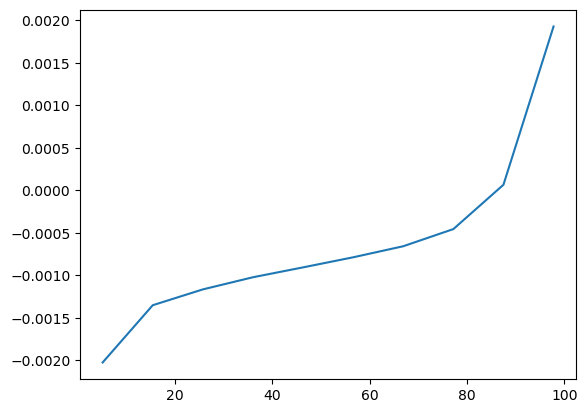

In [60]:
te_sub = te_dataset[te_dataset.index % 650 == 325]
plt.plot(te_sub.pct, te_sub.te)

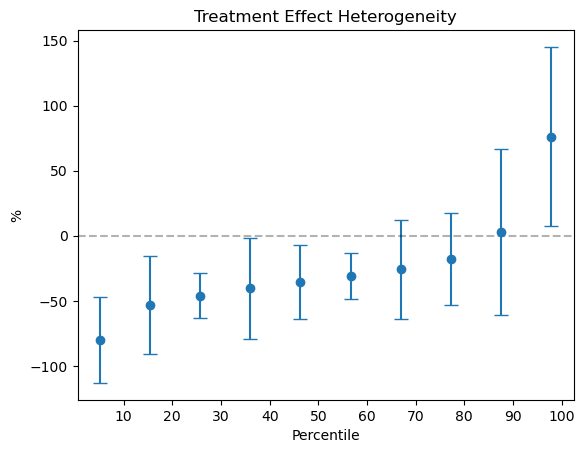

In [66]:
plt.errorbar(te_sub.pct, te_sub.te / 0.0025326 * 100, yerr=(te_sub.te_h-te_sub.te_l)/2/ 0.0025326 * 100, fmt="o", capsize=5)
plt.xlabel('Percentile')
plt.ylabel('%')
plt.title("Treatment Effect Heterogeneity")
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.xticks(np.linspace(10, 100, 10))
plt.savefig(f"..\\results\\split 1\\figures\\Treatment Effect bw Ad 1, 3.jpg", dpi=600)
plt.show()